<img src="images/banner.png" align="left">

# Table of Contents
* [1.0 Introduction](#intro)
* [2.0 System Setup](#setup)
    * [2.1 Hardware Setup](#hsetup)
    * [2.2 Software / Firmware Setup](#ssetup)
* [3.0 Program DAC](#dac)
* [4.0 Capture ADCs](#adc)
* [5.0 Capture OPFB](#opfbcap)
* [6.0 Plot OPFB](#opfbplot)
    * [6.1 Detailed OPFB Plot](#opfbplot2)

# 1.0 Introduction <a class="anchor" id="intro"></a>

This notebook walks through a breif example showing how to generate an arbitrary waveform and channelize it using a 4096-channel, 50% overlapping polyphase filter bank on an [RFSoC4x2](https://www.amd.com/en/corporate/university-program/aup-boards/rfsoc4x2.html) with external loopback via the integrated RF Data Converter. This notebook demonstrates some of the basic functions we have developed to support the readout of two-thousand multiplexed superconducting detectors. This work is part of a broader effort in Ben Mazin's group at UCSB to develop instruments featuing arrays of cryogenic detectors for astronomical, biological, and quantum imaging applications. Check out our [lab website](https://web.physics.ucsb.edu/~bmazin/) to learn more about the research group. To learn more about our FPGA-based readout, check out our [latest publication on arXiv](https://arxiv.org/abs/2406.09764). The full project continually under development but the current state is available on [Github](https://github.com/MazinLab/MKIDGen3).

# 2.0 System Setup <a class="anchor" id="setup"></a>

## 2.1 Hardware Setup <a class="anchor" id="hsetup"></a>

To fully run this notebook, you will need to have an RFSoC4x2 board with a suitable PYNQ image ([see README](https://github.com/MazinLab/RFSoC_OPFB/tree/rfsoc4x2?tab=readme-ov-file#hardware)). Connect the system in RFDC loopback by connecting **DAC A to ADC C and DAC B to ADC D** as shown in the image below. This will allow us to access 4 GHz of Nyquist bandwith in the -2048 to 2048 MHz range with DAC A and ADC C acting as the I channel and DAC B and ADC D acting as the Q channel. You may optionally provide a 10 MHz reference to CLK_IN (J14). The PPS input shown connected in the picture below was used for another test but is not necessary for this project.

<img src="images/direct_loopback.png" style="height:500px">

## 2.2 Software / Firmware Setup <a class="anchor" id="ssetup"></a>
Follow the instructions in the [README](https://github.com/MazinLab/RFSoC_OPFB/blob/rfsoc4x2/README.md#software) to download the `mkidgen3` python package to your RFSoC if you haven't already.

### Imports

In [1]:
from pynq import Overlay
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [2]:
import mkidgen3
import mkidgen3.plotting as plt_util
from mkidgen3.server.waveform import WaveformFactory, TabulatedWaveform
from mkidgen3.server.feedline_config import WaveformConfig

### Configure RFDC Clocks, Download Overlay

The following cell programs the RFDC LMK and LMX reference clocks to support the ADC and DAC 4.096 GSPS sampling rate. If you have an external 10 MHz reference connected to CLK_IN (J14), set `clock_source = 'external'` otherwise use  `clock_source = 'internal'`. Because the RFSoC4x2 DACs are on seperate tiles, [Multi-Tile Synchronization (MTS)](https://docs.amd.com/r/en-US/pg269-rf-data-converter/Multi-Tile-Synchronization) may be needed to acheive good synchronization between the I and Q DACs. MTS is optional but we find without it image tones appear at the -20 dB level whereas MTS can push the undesired images down to -40 dB.

In [3]:
# Configure RFDC clocks
mkidgen3.drivers.rfdcclock.configure(programming_key='4.096GSPS_MTS_dualloop', clock_source='external')

In [4]:
# Download Overlay
bitstream='/home/xilinx/streaming_test1.bit'
ol = Overlay(bitstream, ignore_version=True, download=True)

In [5]:
# Perform Multi-Tile Synchronization
ol.rfdc.enable_mts()

# 3.0 Program DAC Table <a class="anchor" id="dac"></a>

## DAC Table IP Overview

The DAC Replay is a Vitis HLS IP. The source code along with the exported IP is available [here](https://github.com/MazinLab/dac-replay/tree/main). The DAC Replay IP is implemented as a 60 URAM look-up-table which totals 2MiB of waveform data. The URAM is programmed with 2^19 complex values where the real and complex parts are each 16-bits. The real and complex signal components are fed to two RFSoC DACs each running at 4.096 GSPS. This allows us to generate arbitrary waveforms in the [-2048 MHz, 2048 MHz) range with 4.096 GHz / 2^19 =  7.8125 KHz resolution. 

The DAC Replay IP supports replaying all 2^19 samples in a loop or a smaller (integer multiple of 16) range of samples. The IP also supports generating a TLAST signal on a group of 16 samples. The IP outputs two 256-bit AXI-4 streams at 256 MHz, one feeds the I DAC and the other the Q DAC.

## Programming

We support several ways to generate a waveform to play out of the DAC table. The DAC table configuration is managed by a `WaveformConfig` which includes the `.configure()` method used to actually program the DAC table. There are several ways to generate the `WaveformConfig` but the recommended way is to use `WaveformFactory` which allows users to specify frequencies, amplitudes, and phases. By default, the amplitudes are set to all unity and the phases are randomized. The `dac_dynamic_range` argument controlls the maximum value of the integers programmed to the DAC look-up-table. Setting `dac_dynamic_range = 1` will set the integer maximum waveform value to 8191 which generates the maximum DAC output.

In [6]:
# Create Waveform Config
tones = np.array([200e6, 200.5e6])
wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=tones, seed=6, dac_dynamic_range=0.5, compute=True))

In [7]:
# Print actual waveform look-up-table integer values
wvfm_cfg.waveform.output_waveform

array([-12488. +4880.j, -13384.  +876.j, -13024. -3212.j, ...,
        -3660.+12888.j,  -7388.+11180.j, -10424. +8424.j])

If you wanted to manually specify the exact DAC integers, this can be done with `TabulatedWaveform` like so:

In [8]:
custom_wvfm = TabulatedWaveform(wvfm_cfg.waveform.output_waveform)
wvfm_cfg2 = WaveformConfig(waveform=custom_wvfm)

This method is not recommened because `WaveformConfig` objects made using `TabulatedWaveform` do not contain information about the frequencies, amplitudes, etc. `TabulatedWaveform` is best reserved for debug purposes such as supplying a ramp to the DAC table.

In [9]:
# Program DAC table and begin playing waveform
ol.dactable.configure(**wvfm_cfg.settings_dict())

# 4.0 Capture ADC Output and Visualize Waveform <a class="anchor" id="adc"></a>

Now that we are playing a signal out of the DACs, we can use the ADCs to capture data to the PL DDR4 and visualize the DAC output in this notebook.

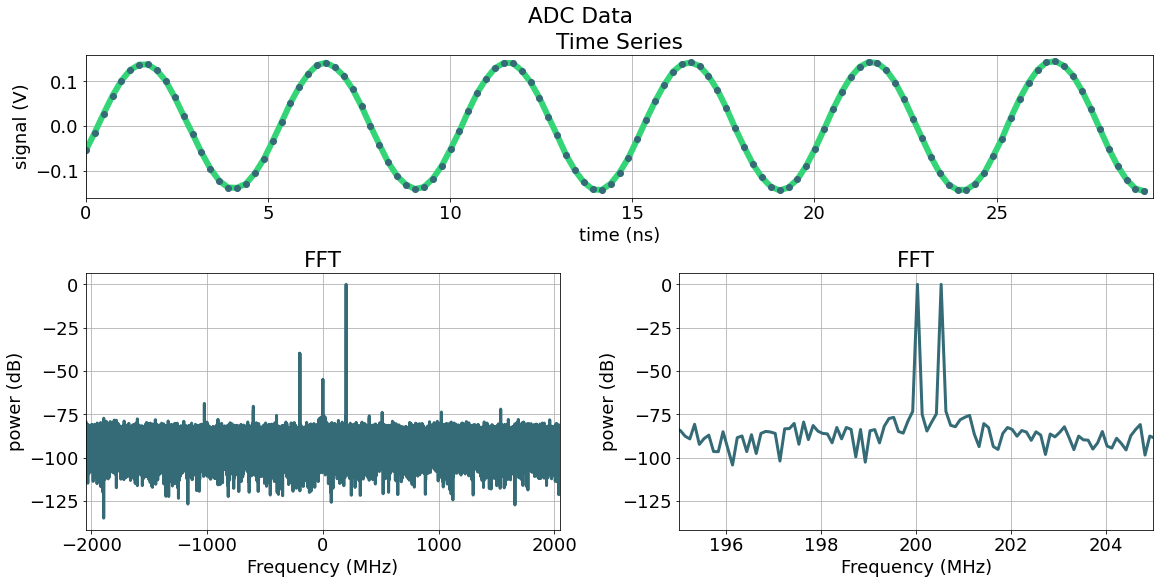

In [10]:
# Capture ADC
x = ol.capture.capture_adc(2**19, complex=False)  # throw away capture to clear any startup garbage
del x
adc_capture_data = ol.capture.capture_adc(2**19, complex=True)
adc_capture_data = adc_capture_data/2**15 # Normalize to 1/2 V
# Plot ADC Data
timerange = (0,120)  # timeseries x axis limits in ns
fftrange= (16, 16 + 20*4096) # timeseries start and stop sample to apply FFT to (defines FFT resolution)
fftzoom = (195, 205) # x axis limits on right FFT plot in Hz
plt_util.adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom)

# 5.0 Capture OPFB Output <a class="anchor" id="opfbcap"></a>

The OPFB is a 4096-channel, 2/1 oversampled 4 GHz channelizer. It takes in 2, 4.096 GSPS data streams--one from an I ADC and the other from a Q ADC, and produces 4096, 2 MHz channels which overlap by 50%. This overlapping feature insures that no matter where a signal exists in-band, it will be able to pass through the channelizer un-attenuated. This IP is the subject of [this publication](https://ieeexplore.ieee.org/document/9336352) and is also documented in this [stand-alone git repo](https://github.com/MazinLab/RFSoC_OPFB).

After being sampled by the ADCs, we can run the data through the OPFB IP and capture the result to the PPL DDR4 for visualization. The following cell allows us to capture the OPFB output. Please note each `n` captures a 4-byte complex sample from all 4096 bins and capturing more than about `n=2**15` samples will likely hang the system.

In [11]:
# Capture N samples from all 4096 OPFB Bins
opfb_raw = mkidgen3.overlay_helpers.capture_opfb(ol, n=1024, raw=True)
# Convert to complex numbers
opfb_fp = opfb_raw[..., 0] + 1j*(opfb_raw[..., 1])

# 6.0 Plot OPFB Output <a class="anchor" id="opfbplot"></a>

Frist let's just plot the whole 4 GHz spectrum. (Executing this cell might take a minute to two.)

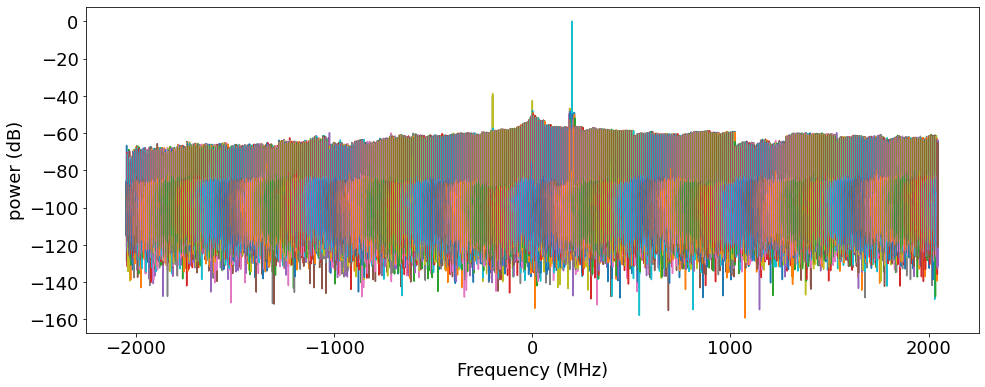

In [12]:
all_bins = np.linspace(0,4095,4096).astype(int).tolist()
with np.errstate(divide='ignore'):
    plt_util.plot_opfb_bins(opfb_fp,all_bins);

## 6.1 Detailed Plot <a class="anchor" id="opfbplot2"></a>

To dig a little deeper we'll use some helper functions to figure out where in the spectrum our tone is and manually make a nice, detailed plot.

In [13]:
from mkidgen3.opfb import opfb_bin_number, opfb_bin_frequencies, opfb_bin_spectrum

In [14]:
tone_idx = opfb_bin_number(wvfm_cfg.waveform.freqs, ssr_raw_order=False)
print(tone_idx)

[2248 2248]


Both tones appear in the same bin, so to make things a little more clear, we will plot a range around these bins.

In [15]:
bins = np.arange(5)+tone_idx[0]-1 # center our tone in the bin range
bin_freqs = opfb_bin_frequencies(bins, opfb_fp.shape[0])* 1e-6 # generate x-axis frequencies for specified bins
with np.errstate(divide='ignore'):
    spectra = opfb_bin_spectrum(np.fft.fftshift(opfb_fp, axes=1), bins) # calculate bin FFT and suppress %0 err

Text(0, 0.5, 'Power (dB)')

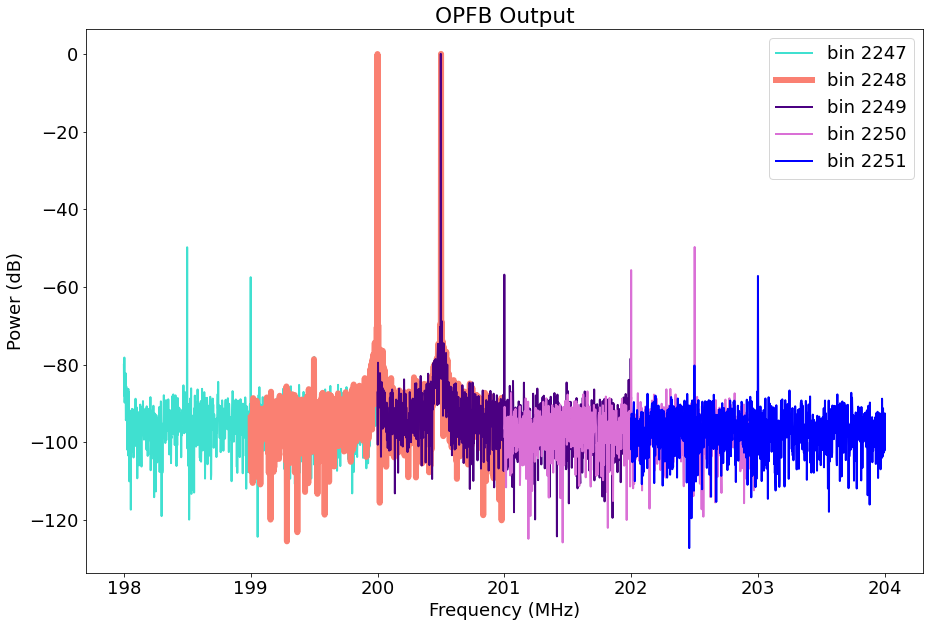

In [16]:
# Nice Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
colors=['turquoise','salmon', 'indigo', 'orchid', 'blue']
for x, y in enumerate(bins):
    if y == tone_idx[0]:
        ax.plot(bin_freqs[:,x], spectra[:,x], linewidth=6, label=f'bin {y}', color=colors[x])
    else:
        ax.plot(bin_freqs[:,x], spectra[:,x], linewidth=2, label=f'bin {y}', color=colors[x])
    ax.legend(loc='upper right')
ax.set_title('OPFB Output')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Power (dB)')

As expected, the two tones appear in the correct places and the 200.5 MHz tone which appears directly in-between bin 2248 and bin 2249 appears in both bins and has the same response in both bins. There are leakage spurs at the -50 dB level which is consistent with the [filter design](https://github.com/MazinLab/gen3-vivado-top/blob/main/data/4_tap_equiripple/4_tap_equirip_channelizer_resp.png). 